# 23mer Classifier Analysis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import cycle
import pickle

from sklearn.metrics import roc_curve, auc
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression,logistic_regression_path, RidgeClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV, KFold, cross_validate
from sklearn.feature_selection import SelectFromModel, RFECV, VarianceThreshold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from scipy import interp

from math import log10, pow, log
from scipy.stats import spearmanr,pearsonr
from statistics import mean

## Load data and Standard Scale non binary features

In [2]:
#Load data
rownames = np.loadtxt(open("/home/pierre/Desktop/Position_Matrix/ML_BIN8020_input23mer_3006.csv", "rb"),delimiter=',', dtype='str')[0,:]
names = np.asarray([_ for _ in rownames])
df = np.loadtxt(open("/home/pierre/Desktop/Position_Matrix/ML_BIN8020_input23mer_3006.csv", "rb"),delimiter=',', usecols=range(1,rownames.shape[0]), dtype='float', skiprows=1)
sgRNA_seq = np.loadtxt(open("/home/pierre/Desktop/Position_Matrix/ML_BIN8020_input23mer_3006.csv", "rb"),delimiter=',', usecols=0, dtype='str', skiprows=1)

#sort by sequence (not by activity/efficiency which is the response variable)
indx = sgRNA_seq.argsort()
df = df[indx,:]

#Standard scale non binary features
sc = StandardScaler()
df[:,1:26] = sc.fit_transform(df[:,1:26])

#Save standardized dataset
pd.DataFrame(np.column_stack((sgRNA_seq, df)), columns=names).to_csv("/home/pierre/Desktop/Position_Matrix/ML_BIN8020_input23mer_3006-scaled.csv",index=False)

#Number of cpus to use for multithreading
n_cpu = 2

### RFECV

In [3]:
#Recursive Feature Elimination with Cross-Validation to remove the irrelevant features

modelnames = [
    "Logistic Regression",
    "Linear SVC",
    "Ridge Classifier",
    "Decision Tree Classifier",
    "GradientBoostingClassifier",
    "Random Forest Classifier"
]

model = [
    LogisticRegression(random_state=0),
    LinearSVC(random_state=0),
    RidgeClassifier(random_state=0),
    DecisionTreeClassifier(random_state=0),
    GradientBoostingClassifier(random_state=0),
    RandomForestClassifier(random_state=0)
]

rfecv = dict()
models=dict()
datasets=dict()
supports = dict()
i=0
for name, clf in zip(modelnames, model):    
    model = RFECV(estimator=clf, 
                    cv=StratifiedKFold(n_splits=10, random_state=0), 
                    scoring='roc_auc', n_jobs=n_cpu)
    rfecv[i] = model
    model.fit(df[:,1:], df[:,0])

    X_new = model.transform(df[:,1:])
    sup = model.get_support(True)
    
    #Insert Column names
    X_new = pd.DataFrame(X_new, columns=names[2:][sup])

    print(X_new.shape)
    
    models[i] = model
    datasets[i] = X_new
    supports[i] = sup
    
    i+=1

(3006, 136)
(3006, 242)
(3006, 144)
(3006, 120)
(3006, 125)
(3006, 405)


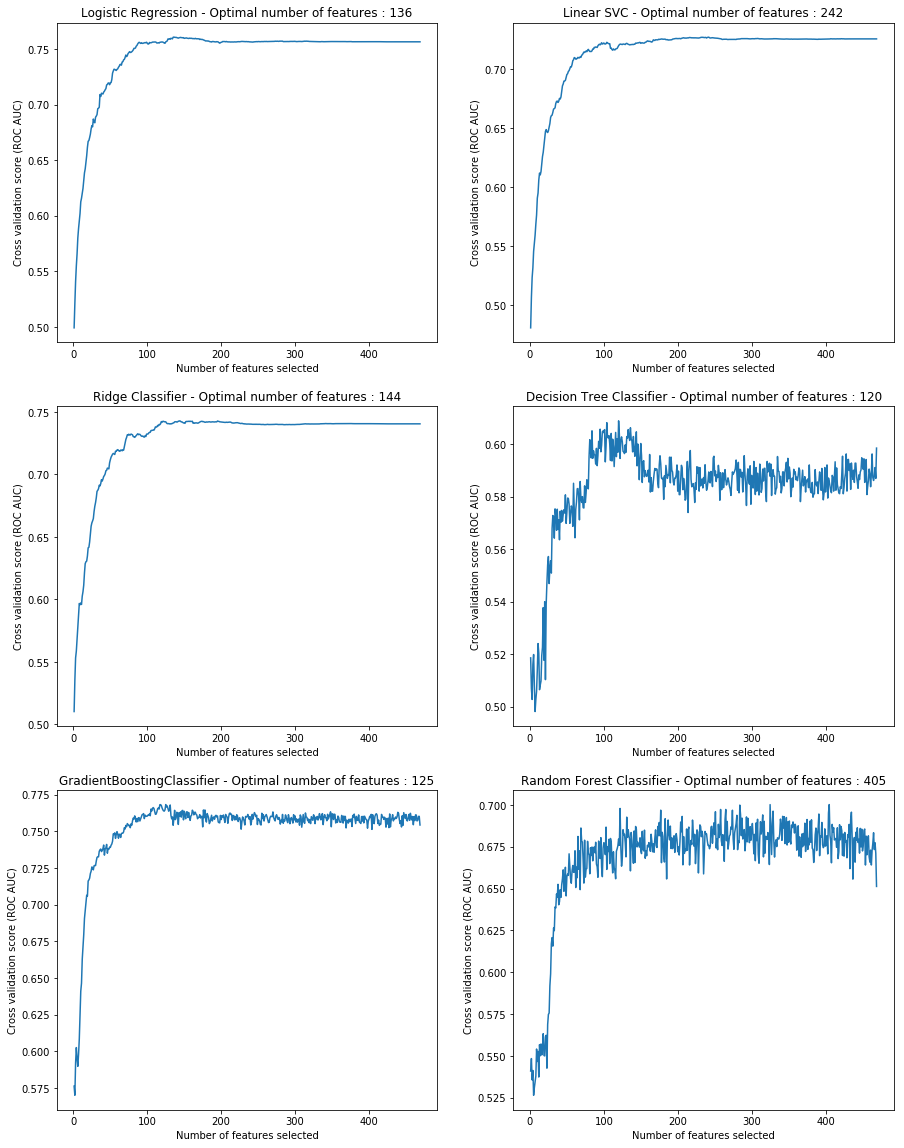

In [4]:
# RFECV to plot
n_groups = 6

# create plot
fig, axes = plt.subplots(nrows=3,ncols=2,figsize=(15,20))
plt.figure()

index = np.arange(n_groups)

for ax, i in zip(axes.flatten(),range(n_groups)):
    rfecv_model = rfecv[i]
    X_newL1 = datasets[i]

    ax.set_xlabel("Number of features selected")
    ax.set_ylabel("Cross validation score (ROC AUC)")
    ax.set_title("%s - Optimal number of features : %d" % (modelnames[i], X_newL1.shape[1]))
    ax.plot(range(1, len(rfecv_model.grid_scores_) + 1), rfecv_model.grid_scores_)
plt.show()

## Hyperparameter Optimization & Performance Evaluation

In [5]:
# find the best hyperparameters for each model and evaluate its performance on the training set

models = [
    LogisticRegression(),
    LinearSVC(),
    RidgeClassifier(),
    DecisionTreeClassifier(),
    GradientBoostingClassifier(),
    RandomForestClassifier()
        ]

# set up params

tuned_parameters = [{'penalty':['l1','l2'],
                     'C': [0.001,0.01,0.1,1,10,100,1000]},
                    {'loss': ['hinge','squared_hinge'],
                     'C': [0.001,0.01,0.1,1,10,100,1000]},
                    {'alpha': np.logspace(log10(10e-5),log10(1.5e5),100)},
                    {'splitter': ['best','random'],
                     'max_depth':[2,4,6,8,10],
                     'min_samples_split':[2,4],
                     'min_samples_leaf':[1,2],
                     'max_features':['auto','sqrt','log2']},
                    {'learning_rate':[0.0001, 0.001, 0.01, 0.1, 0.2, 0.3],
                     'n_estimators':[50,100,150,200],
                     'max_depth':[2,4,6,8,10],
                     'min_samples_split':[2,4],
                     'min_samples_leaf':[1,2],
                     'max_features':['auto','sqrt','log2']},
                    {'n_estimators':[50,100,150,200],
                     'max_depth':[2,4,6,8,10],
                     'min_samples_split':[2,4],
                     'min_samples_leaf':[1,2],
                     'max_features':['auto','sqrt','log2']}
                   ]
grid = dict()

for i in datasets :
    print(datasets[i].shape)
    grid[i] = dict()
    for j in range(len(models)):
        
        print(str(models[j]))
        print(str(tuned_parameters[j]))
        print()
        
        #Inner CV for parameter Optimization
        grid[i][j] = GridSearchCV(models[j], 
                                  tuned_parameters[j], 
                                  cv=KFold(n_splits=10, shuffle=True, random_state=i+j), 
                                  scoring='roc_auc',n_jobs=n_cpu).fit(datasets[i], df[:,0])

(3006, 136)
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
{'penalty': ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)
{'loss': ['hinge', 'squared_hinge'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
        max_iter=None, normalize=False, random_state=None, solver='auto',
        tol=0.001)
{'alpha': array([1.00000000e-04, 1.23790635e-04, 1.53241213e-04, 1.89698271e-04,
       2.34828694e-04, 2.90695931e-04, 3.59854338e-04, 4.45465970e-04,
       5.51445153e-04, 6.82637457

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
{'n_estimators': [50, 100, 150, 200], 'max_depth': [2, 4, 6, 8, 10], 'min_samples_split': [2, 4], 'min_samples_leaf': [1, 2], 'max_features': ['auto', 'sqrt', 'log2']}

(3006, 144)
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
{'penalty': ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=Tr

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
{'n_estimators': [50, 100, 150, 200], 'max_depth': [2, 4, 6, 8, 10], 'min_samples_split': [2, 4], 'min_samples_leaf': [1, 2], 'max_features': ['auto', 'sqrt', 'log2']}

(3006, 125)
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
{'penalty': ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=Tr

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
{'n_estimators': [50, 100, 150, 200], 'max_depth': [2, 4, 6, 8, 10], 'min_samples_split': [2, 4], 'min_samples_leaf': [1, 2], 'max_features': ['auto', 'sqrt', 'log2']}



In [5]:
#Save the best model and it's associated dataset and relevant features
data = {'grid': grid,
        'datasets' : datasets,
        'supports' : supports}

pickle_out = open("23mer_GRID.pickle","wb")
pickle.dump(data, pickle_out)
pickle_out.close()

In [4]:
# # Uncomment to load the models
# pickle_in = open("23mer_GRID.pickle","rb")
# p_load = pickle.load(pickle_in)

# grid = p_load['grid']
# datasets = p_load['datasets']
# supports = p_load['supports']

## ROC AUC Performance plot of the models on the training set

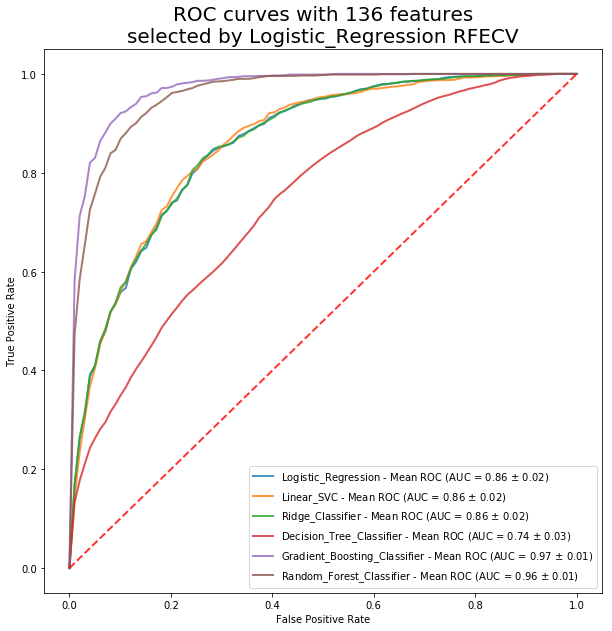

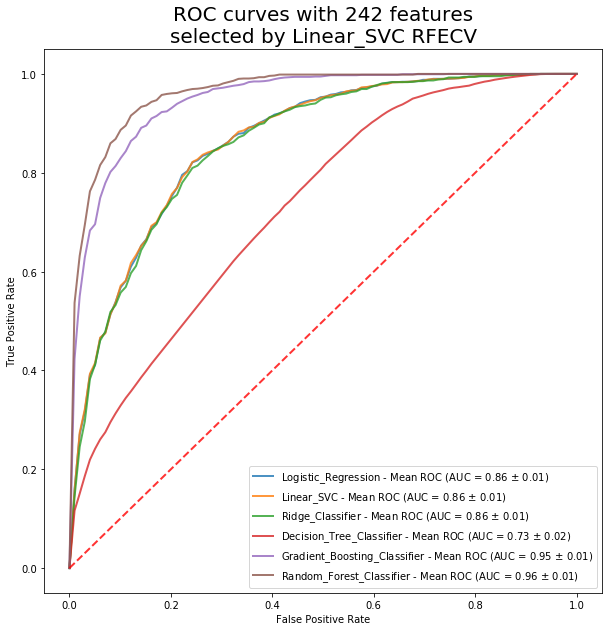

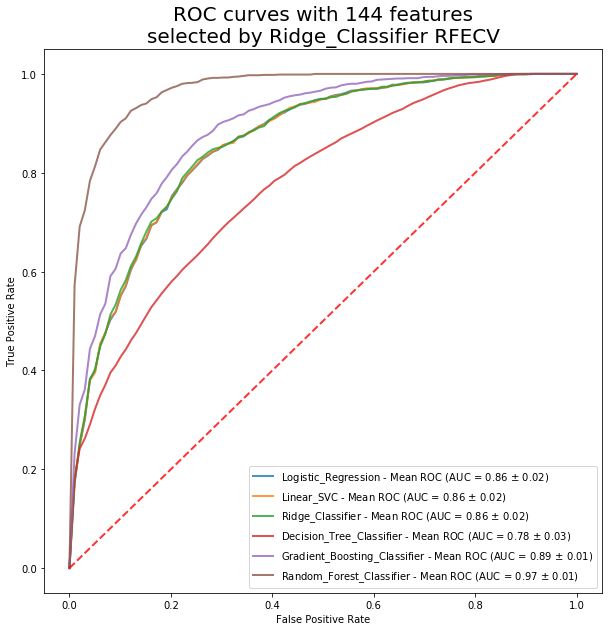

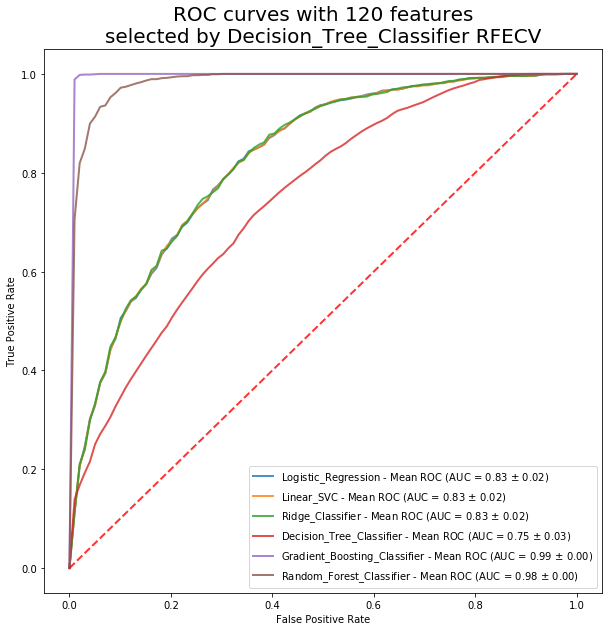

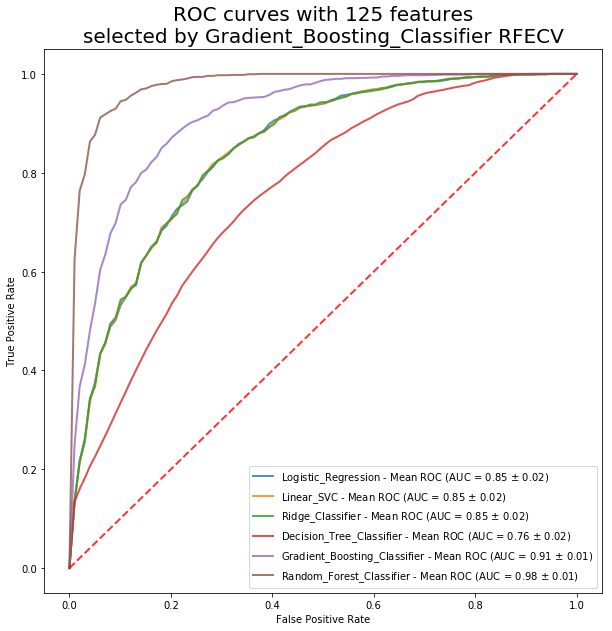

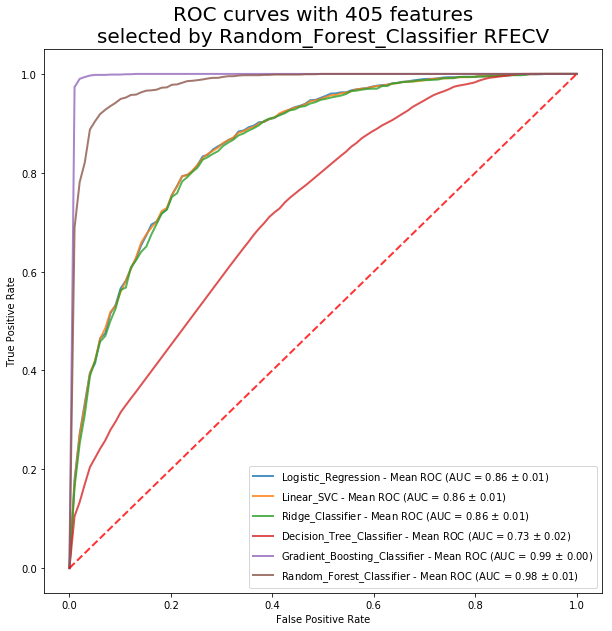

In [7]:
modelnames = [
    "Logistic_Regression",
    "Linear_SVC",
    "Ridge_Classifier",
    "Decision_Tree_Classifier",
    "Gradient_Boosting_Classifier",
    "Random_Forest_Classifier"
]

for FS in range(len(datasets)):
    X =datasets[FS]
    y = df[:,0]

    n_features = X.shape[1]

    plt.figure(figsize=(10,10))

    cv = StratifiedKFold(n_splits=10)

    for i in range(len(grid[FS])):
        classifier = grid[FS][i].best_estimator_

        tprs = []
        aucs = []
        mean_fpr = np.linspace(0, 1, 100)

        j = 0
        for train, test in cv.split(X, y):
            if hasattr(classifier, "decision_function"):
                probas_ = classifier.decision_function(X.iloc[test])
            else:
                probas_ = classifier.predict_proba(X.iloc[test])[:, 1]

            # Compute ROC curve and area the curve
            fpr, tpr, thresholds = roc_curve(y[test], probas_)
            tprs.append(interp(mean_fpr, fpr, tpr))
            tprs[-1][0] = 0.0
            roc_auc = auc(fpr, tpr)
            aucs.append(roc_auc)
            #ax.plot(fpr, tpr, lw=1, alpha=0.3
                     #,label='ROC fold %d (AUC = %0.2f)' % (j, roc_auc))

            j += 1
        

        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0
        mean_auc = auc(mean_fpr, mean_tpr)
        std_auc = np.std(aucs)
        plt.plot(mean_fpr, mean_tpr,
                 label=r'%s - Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (modelnames[i],mean_auc, std_auc),
                 lw=2, alpha=.8)

        std_tpr = np.std(tprs, axis=0)
        tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
        tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
        #plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,label=r'$\pm$ 1 std. dev.')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curves with %d features\nselected by %s RFECV' % (n_features,modelnames[FS]), fontsize=20)
    plt.legend(loc="lower right")

    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Luck', alpha=.8)   
    plt.savefig('ROC_curves_comparison_%d_features-%s_RFECV' % (n_features,modelnames[FS]), fontsize=20)
    plt.show()

In [8]:
#Save the best model
#first index of the grid is the dataset, second index is the model
data = {
    'model': grid[3][4].best_estimator_,
    'df_indexes': supports[3]
}

pickle_out = open("23mer_120FS_GBC_BINmodel.pickle","wb")
pickle.dump(data, pickle_out)
pickle_out.close()

## ROC AUC Performance plot of the models on the test set

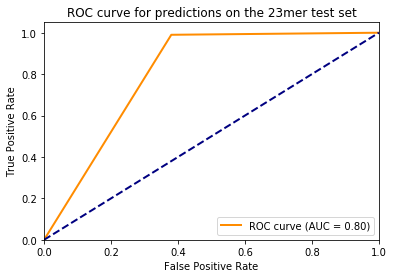

In [3]:
scoredf = np.loadtxt(open("/home/pierre/Desktop/Position_Matrix/Analysis-CLASS_Test_Set_Droso.csv", "rb"), delimiter=',', usecols=(4,11), dtype='float', skiprows=1)
y_test = scoredf[:,0]
y_score = scoredf[:,1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for predictions on the 23mer test set')
plt.legend(loc="lower right")
plt.show()

## Plot the training predictions according to the true efficiencies

In [6]:
scoredf = np.loadtxt(open("/home/pierre/Desktop/Position_Matrix/Analysis-23mer_sgRNA_7514predictions.csv", "rb"), delimiter=',', usecols=(1,3), dtype='float', skiprows=1)
indx = scoredf[:,0].argsort()
scoredf = scoredf[indx,:]


dic_scores = dict()
k=0
for i in np.arange(0,1,0.1):
    dic_scores[k]= scoredf[np.where((scoredf[:,0]>=i) & (scoredf[:,0]<i+0.1)),]
    k+=1
#print(dic_scores)


npRed = list()
npGreen = list()
for i in dic_scores:
    npRed.append(len(np.where((dic_scores[i][0][:,1]==0))[0])/len(dic_scores[i][0][:,1]))
    npGreen.append(len(np.where((dic_scores[i][0][:,1]==1))[0])/len(dic_scores[i][0][:,1]))

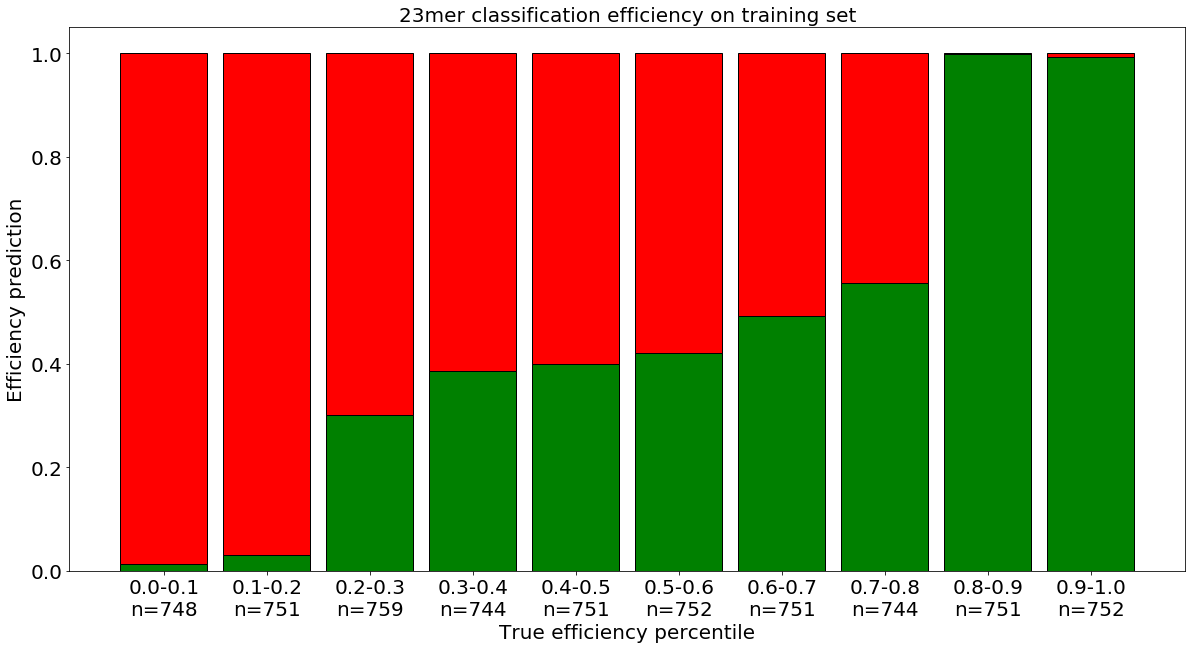

In [7]:
# Data
r = [0,1,2,3,4,5,6,7,8,9]
raw_data = {'greenBars': npGreen, 
            'redBars': npRed
           }
df = pd.DataFrame(raw_data)
 
# From raw value to percentage
totals = [i+j for i,j in zip(df['greenBars'], df['redBars'])]
greenBars = [i / j  for i,j in zip(df['greenBars'], totals)]
redBars = [i / j for i,j in zip(df['redBars'], totals)]
 
# plot
plt.figure(figsize=(20,10))
plt.rc('axes', titlesize=20)
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
barWidth = 0.85
names = ('0.0-0.1\nn=%s' % len(dic_scores[0][0][:,0]),
         '0.1-0.2\nn=%s' % len(dic_scores[1][0][:,0]),
         '0.2-0.3\nn=%s' % len(dic_scores[2][0][:,0]),
         '0.3-0.4\nn=%s' % len(dic_scores[3][0][:,0]),
         '0.4-0.5\nn=%s' % len(dic_scores[4][0][:,0]),
         '0.5-0.6\nn=%s' % len(dic_scores[5][0][:,0]),
         '0.6-0.7\nn=%s' % len(dic_scores[6][0][:,0]),
         '0.7-0.8\nn=%s' % len(dic_scores[7][0][:,0]),
         '0.8-0.9\nn=%s' % len(dic_scores[8][0][:,0]),
         '0.9-1.0\nn=%s' % len(dic_scores[9][0][:,0]))
# Create green Bars
plt.bar(r, greenBars, color='g', edgecolor='black', width=barWidth)
# Create red Bars
plt.bar(r, redBars, bottom=greenBars, color='red', edgecolor='black', width=barWidth)


# Custom x axis
plt.xticks(r, names)
plt.title("23mer classification efficiency on training set")
plt.xlabel("True efficiency percentile", fontsize=20)
plt.ylabel("Efficiency prediction", fontsize=20)
 
# Show graphic
plt.show()

## Plot the testing predictions according to the true efficiencies

In [2]:
scoredf = np.loadtxt(open("/home/pierre/Desktop/Position_Matrix/Analysis-Test_Set_Droso.csv", "rb"), delimiter=',', usecols=(4,11), dtype='float', skiprows=1)
indx = scoredf[:,0].argsort()
scoredf = scoredf[indx,:]


dic_scores = dict()
k=0
for i in np.arange(0,1,0.1):
    dic_scores[k]= scoredf[np.where((scoredf[:,0]>=i) & (scoredf[:,0]<i+0.1)),]
    k+=1
#print(dic_scores)


npRed = list()
npGreen = list()
for i in dic_scores:
    npRed.append(len(np.where((dic_scores[i][0][:,1]==0))[0])/len(dic_scores[i][0][:,1]))
    npGreen.append(len(np.where((dic_scores[i][0][:,1]==1))[0])/len(dic_scores[i][0][:,1]))

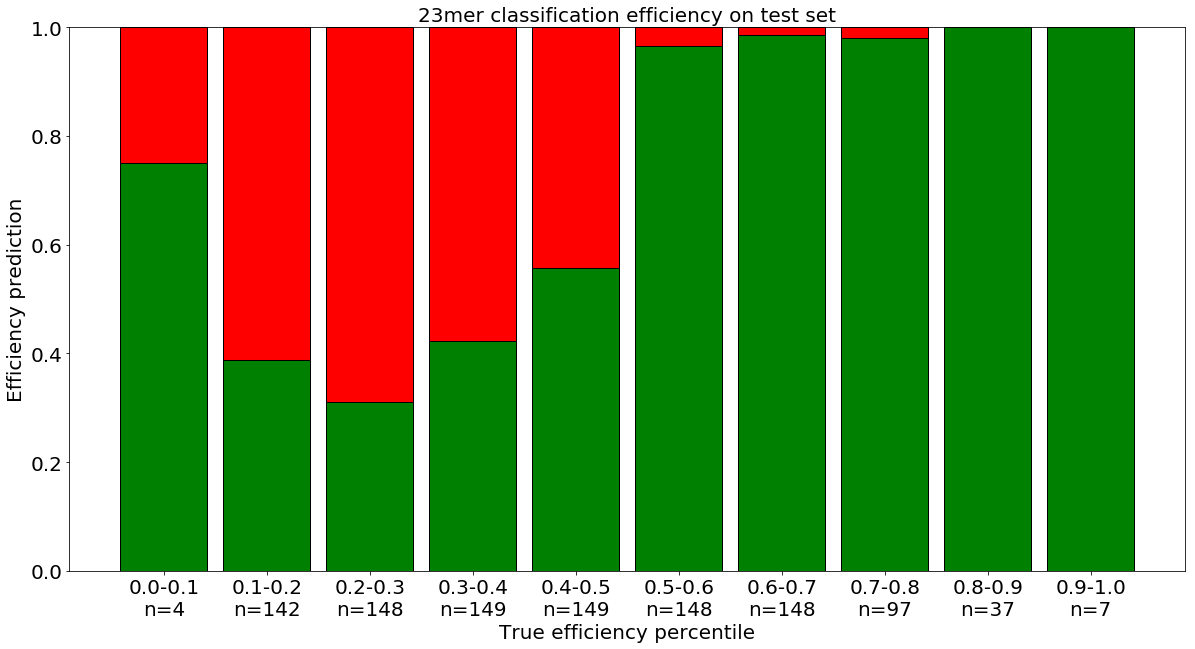

In [3]:
# Data
r = [0,1,2,3,4,5,6,7,8,9]
raw_data = {'greenBars': npGreen, 
            'redBars': npRed
           }
df = pd.DataFrame(raw_data)
 
# From raw value to percentage
totals = [i+j for i,j in zip(df['greenBars'], df['redBars'])]
greenBars = [i / j  for i,j in zip(df['greenBars'], totals)]
redBars = [i / j for i,j in zip(df['redBars'], totals)]
 
# plot
plt.figure(figsize=(20,10))
plt.rc('axes', titlesize=20)
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
barWidth = 0.85
names = ('0.0-0.1\nn=%s' % len(dic_scores[0][0][:,0]),
         '0.1-0.2\nn=%s' % len(dic_scores[1][0][:,0]),
         '0.2-0.3\nn=%s' % len(dic_scores[2][0][:,0]),
         '0.3-0.4\nn=%s' % len(dic_scores[3][0][:,0]),
         '0.4-0.5\nn=%s' % len(dic_scores[4][0][:,0]),
         '0.5-0.6\nn=%s' % len(dic_scores[5][0][:,0]),
         '0.6-0.7\nn=%s' % len(dic_scores[6][0][:,0]),
         '0.7-0.8\nn=%s' % len(dic_scores[7][0][:,0]),
         '0.8-0.9\nn=%s' % len(dic_scores[8][0][:,0]),
         '0.9-1.0\nn=%s' % len(dic_scores[9][0][:,0]))
# Create green Bars
plt.bar(r, greenBars, color='g', edgecolor='black', width=barWidth)
# Create red Bars
plt.bar(r, redBars, bottom=greenBars, color='red', edgecolor='black', width=barWidth)


# Custom x axis
plt.xticks(r, names)
plt.title("23mer classification efficiency on test set")
plt.xlabel("True efficiency percentile", fontsize=20)
plt.ylabel("Efficiency prediction", fontsize=20)
 
# Show graphic
plt.show()